In [1]:

from sklearn.metrics import accuracy_score
from train_set import Training_set
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

In [2]:
# Split the combined dataframe into features and labels
X = Training_set.iloc[:, :-1]
#Y has the last col with labels
Y = Training_set.iloc[:, -1]
X1 = X
Y1 =  Y


In [5]:
X1, Y1 = make_classification(
    n_samples=500,
    n_features=10,
    n_informative=3,
    n_redundant=2,
    n_repeated=0,
    n_classes=8,
    n_clusters_per_class=1,
    class_sep=0.8,
    random_state=0,
)

In [6]:

min_features_to_select = 1  # Minimum number of features to consider
clf = LogisticRegression()
cv = StratifiedKFold(10)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X1, Y1)

print(f"Optimal number of features: {rfecv.n_features_}")


Optimal number of features: 4


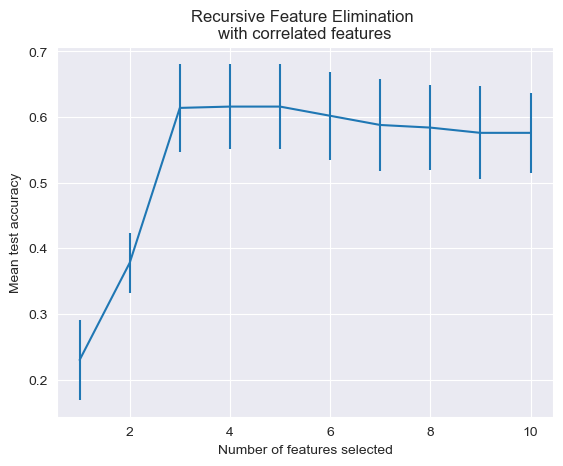

In [5]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()


In [7]:
# initialize the accuracy score list
accuracy_scores = []
skf2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# parameter tuning each fold
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]
              }
best_params_list = []
#skf2.get_n_splits(X, Y)
for train_index, test_index in skf2.split(X, Y):
    Xfold2_train, Xfold2_test = X.iloc[train_index], X.iloc[test_index]
    Yfold2_train, Yfold2_test = Y.iloc[train_index], Y.iloc[test_index]

    # Define the Random Forest model
    rf_model = RandomForestClassifier(random_state=42)

    # Use GridSearchCV to search over the parameter grid
    grid_search = GridSearchCV(rf_model, param_grid=param_grid, cv=5)

    # Fit the grid search to the training data
    grid_search.fit(Xfold2_train, Yfold2_train)

    best_params_list.append(grid_search.best_params_)

    # Create a random forest classifier
    rf = RandomForestClassifier(n_estimators=50, random_state=42)

    # Create the RFE object and fit it
    rfe = RFE(estimator=rf, n_features_to_select=5, step=1)
    rfe = rfe.fit(Xfold2_train, Yfold2_train)

    print("rfe done")
    # Get the selected features
    selected_features = X.columns[rfe.support_]
    X_rfe = pd.concat([X[selected_features]], axis=1)

    clf = RandomForestClassifier(max_depth= 5, min_samples_leaf = 2, min_samples_split = 5, n_estimators= 200, random_state=42)

    clf.fit(Xfold2_train, Yfold2_train)
    print("clf done")
    # define the cross validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    Xfold = X_rfe.values

    # loop over each fold ( fold= fold counter), train & test indices of the samples in each fold
    for train_index, test_index in skf.split(Xfold, Y):
        Xfold_train, Xfold_test = Xfold[train_index], Xfold[test_index]
        Yfold_train, Yfold_test = Y.iloc[train_index], Y.iloc[test_index]

        #Train the classifier on the training data
        clf.fit(Xfold_train, Yfold_train)

         # Test the classifier on the test data
        y_pred = clf.predict(Xfold_test)

        # Compute the accuracy score and append it to the list of scores
        score = accuracy_score(Yfold_test, y_pred)
        accuracy_scores.append(score)

rfe done
clf done
rfe done
clf done
rfe done
clf done
rfe done
clf done
rfe done
clf done


In [10]:
avg_best_params = {}
for param_name in param_grid.keys():
    param_values = [params[param_name] for params in best_params_list]
    avg_best_params[param_name] = np.median(param_values)

print("Average best hyperparameters:", avg_best_params)

# Calculate the mean accuracy score and its standard deviation
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
print("Mean accuracy: {:.2f}%".format(mean_accuracy*100))
print("Standard deviation: {:.2f}%".format(std_accuracy*100))


Average best hyperparameters: {'n_estimators': 200.0, 'max_depth': 5.0, 'min_samples_split': 5.0, 'min_samples_leaf': 2.0}
Mean accuracy: 82.80%
Standard deviation: 9.70%


[0.17219309 0.08509666 0.57685489 0.04262674 0.12322862]
Selected features: Index([3, 1, 5, 2, 4], dtype='object')


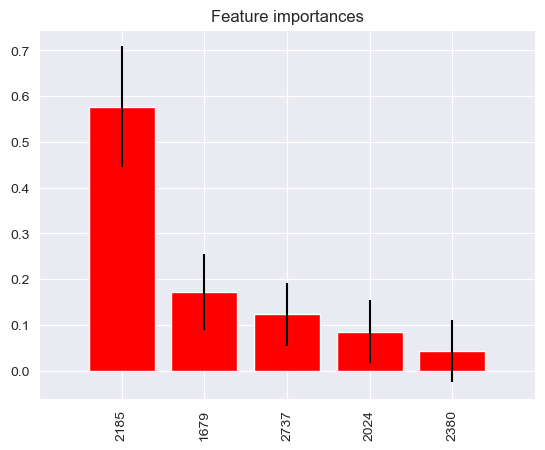

In [11]:
importances = clf.feature_importances_
print(importances)
n = 10
indices = importances.argsort()[::-1][:n]
selected_features2 = X.columns[indices]
print("Selected features:", selected_features2)
# Visualize the feature importances
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_rfe.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_rfe.shape[1]), X_rfe.columns[indices], rotation=90)
plt.xlim([-1, X_rfe.shape[1]])
plt.show()

<Axes: >

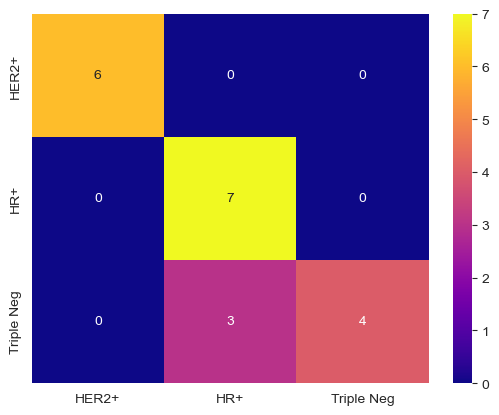

In [ ]:
#dokimazw lasso einai pio grigoro
#VIF for numeric features and chi squared for categorical
